## Nonlinear pulse propagation

From Hamerly's paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import scipy

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [2]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

In [3]:
#Input parameters
la = 1.5 #um
lb = la/2 #um
L = 2 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5 !?

p = 1.1 #normalized power
l = 0 #detuning

phi0 = pi*l

### Pump

Gaussian pulse:
$$A(t) = exp(-t^2/t_p^2)$$

$$t_p = \frac{t_d}{\sqrt{4 \log{2}}}$$

Sampling Rate = 0.12903225806451246 ps


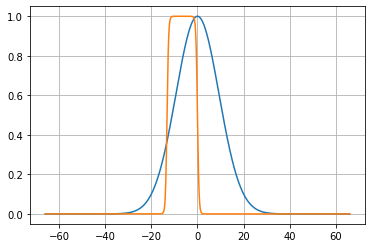

In [4]:
#tp = td/np.sqrt(4*np.log(2)) #tp for Gaussian pulse

N = 1024 #Fourier size
xtra = 5
t = np.linspace(-xtra*Tp, xtra*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')
Omega = 2*pi*np.fft.fftfreq(t.size, ts)

# b = p*b0*np.exp(-t**2/Tp**2)
Tp1 = -Tp
Tp2 =  0
b_shape = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
a_shape = np.exp(-t**2/(Tp)**2)

plt.plot(t,a_shape,t,b_shape)
plt.grid()

# b = p*b0*b
# plt.figure()
# plt.plot(t,a)

## Linear Operators

In [5]:
h = 0.1 #Distance step Size

#Linear operator (Waveguide)
Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h/2)
Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h/2)

## Single Pass

In [6]:
def single_pass(a,b,Da,Db,L,h):
    zi = 0
    while zi<L:
        #Linear half step (front)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Nonlinear step
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)

        #Integral for b
        b = b - 0.5*h*epsilon*a*a
        
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        
        #Linear half step (back)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Next z
        zi = zi+h
    return a,b

## OPO

In [71]:
def opo(L=40, alpha = 0.00691,  u = 0.329, Tp = 13.2, b2a = 1.12e-4, 
        b3a = 3.09e-5, b2b = 4.06e-4, b3b = 2.51e-5, epsilon = 5.16e-5,
       G0 = 2.5, b0 = 3.84e2, p = 1.1, phi0=0):

    h = 0.5 #Distance step Size

    #Linear operator (Waveguide)
    Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h/2)
    Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h/2)
    
    #Feedback response
    fb = np.sqrt(1/G0)*np.exp(1j*phi0)
    
    N = 1000 #Max number of loops
    a = a_shape
    a_prev = a
    Vdiff = np.zeros((N,1))
    
    for kn in range(N):
        b = b0*p*b_shape
        a,b = single_pass(a,b,Da,Db,L,h)

        #Power calc
        Pa = scipy.integrate.simps(np.abs(a)**2,t)

        #Check if steady state at output of section
        Pdiff = scipy.integrate.simps((np.abs(a_prev - a)**2),t)
        diff = Pdiff/Pa*100
        Vdiff[kn] = diff
        a_prev = a
        if diff<1e-3:
            break
            
        #Apply feedback
        a = a*fb
        
    return a, Pa

In [72]:
#Sweep detuning
phi0 = np.arange(-0.4,0.4,0.05)

a_output = np.zeros((phi0.size,N), dtype=complex)

# 
for k in range(phi0.size):
    a_output[k,:], Pa = opo(phi0=phi0[k], p=1.3)
    
    pc = str(((k+1)/phi0.size)*100) + '% complete'
    print('Phi0 = ' + str(round(phi0[k],5)) + ' done; ' + pc)

Phi0 = -0.4 done; 6.25% complete
Phi0 = -0.35 done; 12.5% complete
Phi0 = -0.3 done; 18.75% complete
Phi0 = -0.25 done; 25.0% complete
Phi0 = -0.2 done; 31.25% complete
Phi0 = -0.15 done; 37.5% complete
Phi0 = -0.1 done; 43.75% complete
Phi0 = -0.05 done; 50.0% complete
Phi0 = -0.0 done; 56.25% complete
Phi0 = 0.05 done; 62.5% complete
Phi0 = 0.1 done; 68.75% complete
Phi0 = 0.15 done; 75.0% complete
Phi0 = 0.2 done; 81.25% complete
Phi0 = 0.25 done; 87.5% complete
Phi0 = 0.3 done; 93.75% complete
Phi0 = 0.35 done; 100.0% complete


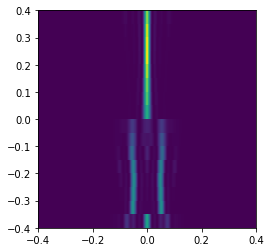

In [73]:
plt.figure()
Spectrum = np.zeros(a_output.shape)

for k in range(phi0.size):
    A = np.fft.fft(a_output[k,:])
    Spectrum[k,:] = np.abs(A)**2

plt.imshow(np.fft.fftshift(Spectrum), extent=(-0.4,0.4,-0.4,0.4))

In [63]:
np.fft.fftshift(Omega)

array([-24.34734307, -24.29978966, -24.25223626, ...,  24.20468285,
        24.25223626,  24.29978966])

In [9]:
# #Input parameters
# la = 1.5 #um
# lb = la/2 #um
# L = 40 #mm
# alpha = 0.00691 #1/mm
# u = 0.329 #ps/mm
# Tp = 13.2 #ps
# b2a = 1.12e-4 #ps^2/mm
# b3a = 3.09e-5 #ps^3/mm
# b2b = 4.06e-4
# b3b = 2.51e-5
# epsilon = 5.16e-5 #ps^0.5/mm
# G0 = 2.5
# b0 = 3.84e2 #ps^0.5 !?

# p = 1.1 #normalized power
# #l = 0 #detuning
# #phi0 = pi*l
# phi0 = -0.2

# fb = np.sqrt(1/G0)*np.exp(1j*phi0)
# ###################################################
# N = 1000 #loops
# a = a_shape
# plot = True

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.canvas.draw()

# a_prev = a
# Vdiff = np.zeros((N,1))
# for kn in range(N):
#     b = b0*p*b_shape
#     a,b = single_pass(a,b,Da,Db,L,h)

#     #Power calc
#     Pa = scipy.integrate.simps(np.abs(a)**2,t)
    
#     #Check if steady state at output of section
#     Pdiff = scipy.integrate.simps((np.abs(a_prev - a)**2),t)
#     diff = Pdiff/Pa*100
#     Vdiff[kn] = diff
#     a_prev = a
#     if diff<1e-3:
#         break
    
#     if plot==True:
#         ax.clear()
#         ax.plot(t, abs(a), t, abs(b));
#         ax.axes.set_ylim(0,2000)
#         ax.text(40,1400,'N=' + str(kn))
#         ax.text(40,1200,'Pa=' + str(round(Pa*1e-8,3)))
#         ax.text(40,1000,'diff=' + str(round(diff,3)))
#         fig.canvas.draw()
#         time.sleep(0.001)

        
#     #Feedback loop
#     a = a*fb
    
    

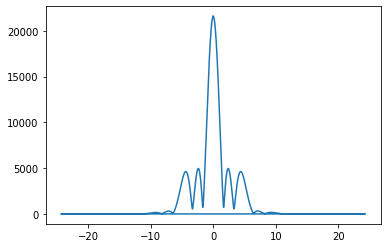

In [40]:
A = np.fft.fft(a)
plt.figure()
plt.plot(Omega, np.abs(A))